In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing

#tf.config.set_visible_devices([], 'GPU')
np.set_printoptions(suppress=True)

In [158]:
class LabelEncoder:
    
    def __init__(self, num_points):
        self.num_points = num_points
    
    def encode(self, chromatogram, locs, scales, asymmetries):
        labels = np.zeros((len(chromatogram)))
        for loc, scale, asymmetry in zip(locs, scales, asymmetries):
            left = np.clip(int((loc-3*scale*(1-asymmetry*3)) * self.num_points), 0, self.num_points)
            right = np.clip(int((loc+3*scale*(1+asymmetry*3)) * self.num_points), 0, self.num_points)
            
            labels[left : right] = 1

        
        return labels
            
    def decode(self, predictions, threshold=0.5):
        index = np.where(predictions[:, 0] > threshold)[0]
        
        t = self.bins[index]
        t += predictions[:, 1][index] * self.grid_size
        return t, predictions[:, 2][index] * self.grid_size, predictions[:, 0][index]

encoder = LabelEncoder(2048)


In [161]:
def asymmetrical_gaussian_peak(x, amplitude, loc, scale, asymmetry):
    # assymetrical_gaussian_peak(..., assymetry=0) is the same as gaussian_peak(...)
    return amplitude * np.exp(-1/2*((x - loc)/(scale + asymmetry*(x - loc)))**2)

def generate_example(_):
    t = np.linspace(0, 1, 2048)
    loc = np.random.uniform(0.25, 0.85)
    scale = np.random.uniform(0.015, 0.02)
    amplitude = np.random.uniform(150, 250)
    asymmetry = np.random.uniform(-0., 0.2)

    g = asymmetrical_gaussian_peak(t, amplitude, loc, scale, asymmetry)

    g += np.random.randn(g.shape[0]) * np.random.uniform(0, 1)
    g += np.random.uniform(-5, 5)
    g += np.linspace(0, 1, len(g)) * np.random.uniform(-10, 10)
    y = encoder.encode(g, [loc], [scale], [asymmetry])
    
    return g, y

with multiprocessing.Pool() as pool:
    data = [i for i in tqdm(pool.imap(generate_example, range(300)), total=300)]
    

y = np.stack([d[1] for d in data])[..., None]
X = np.stack([d[0] for d in data])[..., None]
t = np.linspace(0, 1, 2048)


  0%|          | 0/300 [00:00<?, ?it/s]

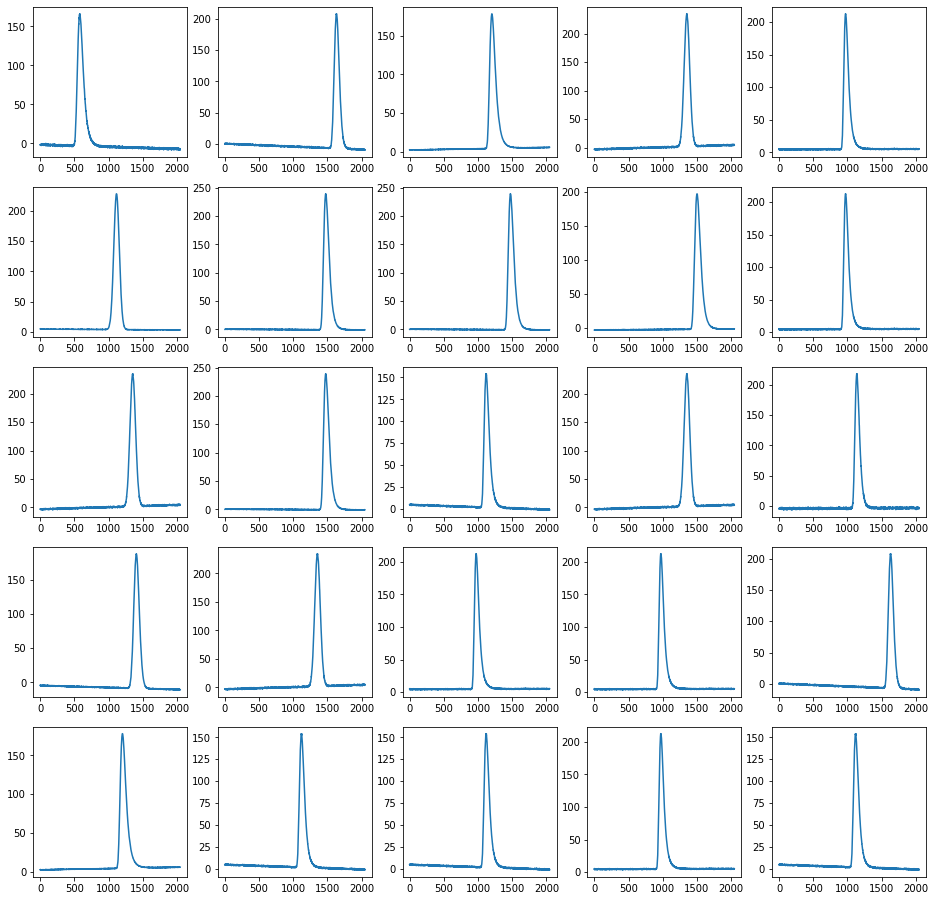

In [162]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16))

for x, ax in zip(X[50:], axes.reshape(-1)):
    
    ax.plot(x[:, 0])

In [163]:
from tensorflow.keras import layers


def conv_block(x, filters, kernel_size, stride, batch_norm=True):
    x = layers.Conv1D(filters, kernel_size, stride, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(x, filters, kernel_size, stride, pool_size=2):
    x = conv_block(x, filters, kernel_size, stride)
    x = conv_block(x, filters, kernel_size, stride)
    x_skip = x
    x = layers.MaxPool1D(pool_size)(x)
    return x, x_skip

def decoder_block(x, x_skip, filters, kernel_size, stride, final_layer):
    x = layers.Concatenate()([x_skip, x])
    
    x = conv_block(x, filters, kernel_size, 1)
    x = conv_block(x, filters, kernel_size, 1)
    if not final_layer:
        x = layers.Conv1DTranspose(filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    else:
        x = layers.Conv1D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    
    return x

def bottleneck_block(x, filters, kernel_size, stride):
    x = conv_block(x, filters, kernel_size, stride)
    x = conv_block(x, filters, kernel_size, stride)
    x = layers.Conv1DTranspose(filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    return x


def UNet():
    
    inputs = layers.Input((2048, 1), dtype='float32')
    x = inputs
    
    x1, x1_skip = encoder_block(x, 64, 9, 1)
    # (2048, 64)
    x2, x2_skip = encoder_block(x1, 128, 9, 1)
    # (1024, 128)
    x3, x3_skip = encoder_block(x2,  256, 9, 1)
    # (512, 256)
    x4, x4_skip = encoder_block(x3, 512, 9, 1)
    # (256,  512)
    x = bottleneck_block(x4, 512, 9, 1)
    # (128,  1024)
    x = decoder_block(x, x4_skip, 256, 9, 2, False)
    # (512, 256)
    x = decoder_block(x, x3_skip, 128, 9, 2, False)
    # (1024, 128)
    x = decoder_block(x, x2_skip, 64, 9, 2, False)
    # (2048, 64)
    x = decoder_block(x, x1_skip, 1, 9, 1, True)

    return tf.keras.Model(inputs=inputs, outputs=x)
# Loss should be categorical crossentropy (with from_logits=True) (no need to customize)
        

In [164]:
model = UNet()
model.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 2048, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_457 (Conv1D)             (None, 2048, 64)     640         input_19[0][0]                   
__________________________________________________________________________________________________
activation_442 (Activation)     (None, 2048, 64)     0           conv1d_457[0][0]                 
__________________________________________________________________________________________________
batch_normalization_442 (BatchN (None, 2048, 64)     256         activation_442[0][0]             
______________________________________________________________________________________

In [165]:
model = UNet()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(X[:290], y[:290], epochs=3, verbose=1)

Epoch 1/3
10/10 [==============================] - 64s 6s/step - loss: 0.8178
Epoch 2/3
10/10 [==============================] - 62s 6s/step - loss: 0.7270
Epoch 3/3
10/10 [==============================] - 64s 6s/step - loss: 0.6799


In [178]:

model.fit(X[:290], y[:290], epochs=3, verbose=1)

Epoch 1/3
10/10 [==============================] - 94s 9s/step - loss: 0.3493
Epoch 2/3
10/10 [==============================] - 65s 6s/step - loss: 0.3434
Epoch 3/3
10/10 [==============================] - 60s 6s/step - loss: 0.3338


In [182]:
prediction[600:1000]

array([[0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.74991846],
       [0.749

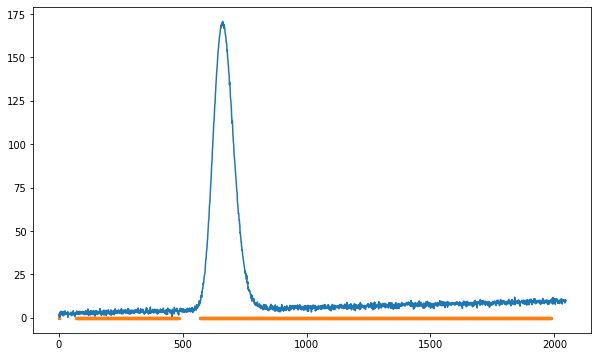

In [180]:
plt.figure(figsize=(10, 6))

ID = 292

prediction = model.predict(X[ID][None])[0]
pos = np.where(tf.nn.sigmoid(prediction) > 0.5)[0]

plt.plot(X[ID])
plt.scatter(pos, [-.1] * len(pos), color='C1', s=5)

(-10.0, 10.0)

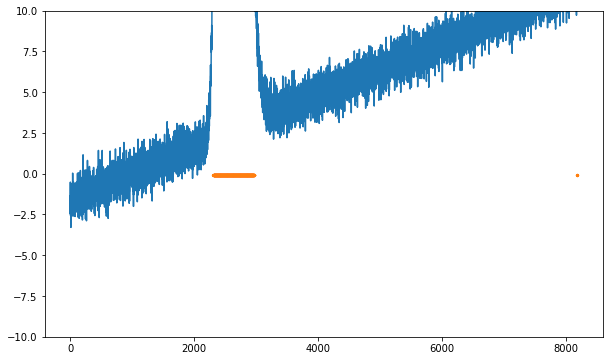

In [147]:
plt.figure(figsize=(10, 6))

ID = 295

prediction = model.predict(X[ID][None])[0]
pos = np.where(tf.nn.sigmoid(prediction) > 0.5)[0]

plt.plot(X[ID])
plt.scatter(pos, [-.1] * len(pos), color='C1', s=5)

plt.ylim(-10, 10)